In [1]:
%load_ext autoreload
%autoreload 2
from lib.ekyn import *
from sklearn.model_selection import train_test_split
from torch import bincount
from lib.utils import plot_eeg_and_labels
from lib.models import MLP
from tqdm import tqdm
from torch import optim
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import numpy as np
import random
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from lib.env import DEVICE
from lib.utils import Windowset
from torch.nn.functional import relu
import json
from lib.ekyn import *
from lib.models import RegNetY
from lib.datasets import EpochedDataset
from torch.utils.data import ConcatDataset

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

PROJECT_DIR = f'projects/6'
with open(f'{PROJECT_DIR}/config.json','r') as f:
    CONFIG = json.load(f)
model = RegNetY(depth=CONFIG['DEPTHI'],width=CONFIG['WIDTHI'],stem_kernel_size=CONFIG['STEM_KERNEL_SIZE'])
criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load(f=f'{PROJECT_DIR}/best.f1.pt', map_location='cpu'))
from lib.ekyn import get_ekyn_ids
train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)

In [ ]:
print(train_idx,test_idx)
trainloader = DataLoader(ConcatDataset([EpochedDataset(idx=idx,condition=condition) for idx in train_idx for condition in ['Vehicle','PF']]),batch_size=CONFIG['BATCH_SIZE'],shuffle=True)
devloader = DataLoader(ConcatDataset([EpochedDataset(idx=idx,condition=condition) for idx in test_idx for condition in ['Vehicle','PF']]),batch_size=CONFIG['BATCH_SIZE'],shuffle=True)

In [ ]:
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=trainloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

In [ ]:
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

In [ ]:
testloader = DataLoader(ConcatDataset([EpochedDataset(idx=test_idx[2],condition=condition) for condition in ['Vehicle','PF']]),batch_size=CONFIG['BATCH_SIZE'],shuffle=True)

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=testloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

criterion = nn.CrossEntropyLoss()
PROJECT_DIR = f'projects/6'
with open(f'{PROJECT_DIR}/config.json','r') as f:
    CONFIG = json.load(f)
model = RegNetY(depth=CONFIG['DEPTHI'],width=CONFIG['WIDTHI'],stem_kernel_size=CONFIG['STEM_KERNEL_SIZE'])
model.load_state_dict(torch.load(f=f'{PROJECT_DIR}/best.f1.pt', map_location='cpu'))

df = pd.DataFrame()

for id in train_idx:
    for condition in ['Vehicle','PF']:
        testloader = DataLoader(EpochedDataset(idx=id,condition=condition),batch_size=CONFIG['BATCH_SIZE'],shuffle=True)
        loss,report,y_true,y_pred,y_logits = evaluate(dataloader=testloader,model=model,criterion=criterion,DEVICE=DEVICE)
        report['condition'] = condition
        report['id'] = id
        df = pd.concat([df,pd.Series(report)],axis=1)

In [ ]:
dft = df.T
dft = dft.melt(id_vars=['condition','id'],value_vars='f1')
dft

In [ ]:

sns.barplot(data=dft,x='id',y='value',hue='condition')
# plt.figure()
# sns.boxplot(data=dft,x='condition',y='value')


In [ ]:
df.T.drop('condition',axis=1).groupby('id').mean()

In [ ]:
df = pd.DataFrame()

plt.figure(figsize=(14,8))
for id in test_idx:
    for condition in ['Vehicle','PF']:
        X,y = load_ekyn_pt(idx=id,condition=condition)
        std,mean = torch.std_mean(X,dim=1)
        df[f'{id}_{condition}'] = std
df_long = df.melt()
df_long[['id','condition']] = df_long.variable.str.split('_',expand=True)
sns.ecdfplot(df_long[df_long.condition == 'PF'],x='value',hue='id',linestyle='--')
sns.ecdfplot(df_long[df_long.condition == 'Vehicle'],x='value',hue='id',linestyle='-')

plt.xlim([0,.0002])

In [2]:
testloader = DataLoader(ConcatDataset([EpochedDataset(idx=idx,condition=condition) for idx in test_idx for condition in ['Vehicle','PF']]),batch_size=4000,shuffle=True)

In [3]:
Xi,yi,idx = next(iter(testloader))

In [21]:
map = {idx:i for i,idx in enumerate(sorted(list(set(idx))))}

In [23]:
idx = [map[id] for id in list(idx)]

/home/andrew/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

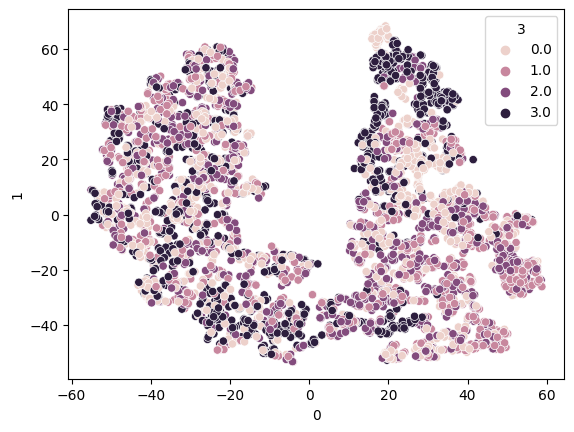

In [27]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
model.cuda()
tsne = TSNE(n_components=2,init='pca',learning_rate='auto')
out = tsne.fit_transform(model(Xi.cuda(),return_embedding=True).detach().cpu(),yi.argmax(axis=1))
sns.scatterplot(data=pd.DataFrame(torch.concat([torch.from_numpy(out),yi.argmax(axis=1).reshape(-1,1),torch.Tensor(idx).reshape(-1,1)],axis=1).numpy()),x=0,y=1,hue=3)

,0,1,2,3
0,19.075283,39.728767,2.0,3.0
1,-20.944721,48.884499,1.0,0.0
2,35.732075,-30.268684,2.0,1.0
3,26.333811,57.174343,2.0,2.0
4,40.593700,-48.086243,0.0,0.0
...,...,...,...,...
3995,25.514427,-18.050270,2.0,1.0
3996,53.787453,-3.494054,2.0,2.0
3997,-17.871132,-14.097547,1.0,3.0
3998,42.360619,-33.045727,2.0,0.0
